In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class CompetitiveHiringAGIEnv(gym.Env):
    """Competitive AGI Race Environment with Two Parties, Team Hiring, and Collaboration"""

    def __init__(self, team_size=5, s0=4.0, alpha=1.5):
        super(CompetitiveHiringAGIEnv, self).__init__()
        # Team management parameters
        self.team_size = team_size
        self.max_skill = team_size
        self.s0 = s0  # AGI threshold skill
        self.alpha = alpha  # Sharpness of AGI probability curve

        # Defining collaboration modes
        self.COLLAB_MODES = {
            'INDEPENDENT': 0,   # Both parties working independently
            'COLLABORATIVE': 1, # Both parties actively collaborating
            'POST_COLLAB': 2,   # Both previously collaborated but now independent
        }

        # Defining party statuses
        self.PARTY_STATUS = {
            'EXPLORING': 0,     # Actively exploring
            'RETREATED': 1,     # Retreated
            'FOUND_AGI': 2,     # Found AGI
        }

        # Collaboration mode (applies to both parties)
        self.collab_mode = self.COLLAB_MODES['INDEPENDENT']

        # Individual party statuses
        self.party_1_status = self.PARTY_STATUS['EXPLORING']
        self.party_2_status = self.PARTY_STATUS['EXPLORING']

        # Track which party has broken collaboration
        self.party_1_broke_collab = False
        self.party_2_broke_collab = False

        # Track resources and teams
        self.party_1_resources = 100
        self.party_2_resources = 100

        # Initialize team members for each party
        self.party_1_team = []
        self.party_2_team = []
        self.party_1_candidate = None
        self.party_2_candidate = None

        # Team statistics
        self.party_1_skill = 0
        self.party_2_skill = 0
        self.party_1_salary = 0
        self.party_2_salary = 0

        # Actions for each agent:
        # 0 = Retreat (stop exploring)
        # 1 = Explore independently
        # 2 = Initiate/continue collaboration
        # 3 = Break collaboration
        # 4+ = Hire candidate (fire team member at index action-4)
        self.action_space = spaces.Tuple((
            spaces.Discrete(4 + team_size),  # Party 1 actions
            spaces.Discrete(4 + team_size)   # Party 2 actions
        ))

        # The observation space includes:
        # - Collaboration mode
        # - Party statuses
        # - Party resources
        # - Team skills and salaries
        # - Candidates
        self.observation_space = spaces.Dict({
            "collab_mode": spaces.Discrete(3),
            "party_1_status": spaces.Discrete(3),
            "party_2_status": spaces.Discrete(3),
            "party_1_resources": spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),
            "party_2_resources": spaces.Box(low=0, high=float('inf'), shape=(1,), dtype=np.float32),
            "party_1_team_skills": spaces.Box(low=0.0, high=1.0, shape=(team_size,), dtype=np.float32),
            "party_1_team_salaries": spaces.Box(low=0.0, high=1.0, shape=(team_size,), dtype=np.float32),
            "party_2_team_skills": spaces.Box(low=0.0, high=1.0, shape=(team_size,), dtype=np.float32),
            "party_2_team_salaries": spaces.Box(low=0.0, high=1.0, shape=(team_size,), dtype=np.float32),
            "party_1_candidate": spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32),
            "party_2_candidate": spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32),
        })

        # Probabilities and rewards
        self.independent_agi_prob_factor = 0.01  # Base prob, will be multiplied by team skill
        self.collaborative_agi_prob_factor = 0.03
        self.post_collab_agi_prob_factor = 0.015

        # Resource dynamics
        self.explore_independent_cost = 1
        self.explore_collaborative_cost = 3
        self.retreat_reward = 10
        self.collaboration_initiation_cost = 5
        self.agi_reward = 100
        self.salary_cost_factor = 0.1  # Salary cost per step

        # Competition penalty: if the opponent finds AGI first
        self.competition_penalty = -50

        # Max environment steps
        self.max_steps = 1000
        self.current_step = 0

        ##########

        # Defining the transition probabilities and rewards for each party
        # Structure: {(party_status, collab_mode): {action: [{next_status, prob, reward, effects}, ...]}}
        self.party_1_transitions = {
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['INDEPENDENT']): {
                1: [  # Explore independently
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(1),
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_2_reward", self.competition_penalty,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(1),
                        "reward": -self.party_1_salary * self.salary_cost_factor, "resource_change": -self.explore_independent_cost, "effects": []}
                ],
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Try to initiate collaboration
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": -self.collaboration_initiation_cost, "resource_change": -self.collaboration_initiation_cost, "effects": []}
                ],
                # Hiring actions will be handled separately
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['COLLABORATIVE']): {
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Explore collaboratively
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(1),
                        "reward": self.agi_reward, "resource_change": -self.explore_collaborative_cost,
                        "effects": [("party_2_status", self.PARTY_STATUS['FOUND_AGI'],
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING']),
                                ("party_2_reward", self.agi_reward,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(1),
                        "reward": -(self.party_1_salary + self.party_2_salary) * self.salary_cost_factor , "resource_change": -self.explore_collaborative_cost, "effects": []}
                ],
                3: [  # Break collaboration
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": 0, "resource_change": 0, "effects": [("party_1_broke_collab", True, lambda: True)]}
                ]
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['POST_COLLAB']): {
                1: [  # Explore after collaboration
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(1),
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_2_reward", self.competition_penalty,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(1),
                        "reward": -(self.party_1_salary * self.salary_cost_factor), "resource_change": -self.explore_independent_cost, "effects": []}
                ],
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
            }
        }

        # Create similar transitions for party 2
        # Create similar transitions for party 2 (properly swapping party references)
        self.party_2_transitions = {
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['INDEPENDENT']): {
                1: [  # Explore independently
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(2),  # Changed 1→2
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_1_reward", self.competition_penalty,  # Changed party_2→party_1
                                    lambda: self.party_1_status == self.PARTY_STATUS['EXPLORING'])]},  # Changed party_2→party_1
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(2),  # Changed 1→2
                        "reward": -self.party_2_salary * self.salary_cost_factor, "resource_change": -self.explore_independent_cost, "effects": []}
                ],
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Try to initiate collaboration
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": -(self.collaboration_initiation_cost), "resource_change": -self.collaboration_initiation_cost, "effects": []}
                ],
                # Hiring actions will be handled separately
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['COLLABORATIVE']): {
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Explore collaboratively
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(2),  # Changed 1→2
                        "reward": self.agi_reward, "resource_change": -self.explore_collaborative_cost,
                        "effects": [("party_1_status", self.PARTY_STATUS['FOUND_AGI'],  # Changed party_2→party_1
                                    lambda: self.party_1_status == self.PARTY_STATUS['EXPLORING']),  # Changed party_2→party_1
                                ("party_1_reward", self.agi_reward,  # Changed party_2→party_1
                                    lambda: self.party_1_status == self.PARTY_STATUS['EXPLORING'])]},  # Changed party_2→party_1
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(2),  # Changed 1→2
                        "reward": -(self.party_1_salary + self.party_2_salary) * self.salary_cost_factor, "resource_change": -self.explore_collaborative_cost, "effects": []}
                ],
                3: [  # Break collaboration
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": 0, "resource_change": 0, "effects": [("party_2_broke_collab", True, lambda: True)]}  # Changed 1->2
                ]
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['POST_COLLAB']): {
                1: [  # Explore after collaboration
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(2),  # Changed 1→2
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_1_reward", self.competition_penalty,  # Changed party_2→party_1
                                    lambda: self.party_1_status == self.PARTY_STATUS['EXPLORING'])]},  # Changed party_2→party_1
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(2),  # Changed 1→2
                        "reward": -self.party_2_salary * self.salary_cost_factor, "resource_change": -self.explore_independent_cost, "effects": []}
                ],
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
            }
        }

        #######

        self.reset()

    def _generate_worker(self, team_skill=0, skill_bias=0.5, skill_uncertainty=0.5, skill_mean=0.5, salary_noise=0.2):
        """Generate a worker with randomized skill and salary."""
        base_skill = np.clip(
            np.random.normal(
                loc=skill_mean + skill_bias * (team_skill / self.max_skill),
                scale=skill_uncertainty
            ), 0, 1
        )

        # Add noise to salary, making it only loosely correlated with skill
        salary = np.clip(
            base_skill + np.random.normal(loc=0.0, scale=salary_noise),
            0.0,
            1.0
        )

        return {"skill": base_skill, "salary": salary}

    def _update_team_stats(self):
        """Update team statistics."""
        self.party_1_skill = sum(w['skill'] for w in self.party_1_team)
        self.party_1_salary = sum(w['salary'] for w in self.party_1_team)

        self.party_2_skill = sum(w['skill'] for w in self.party_2_team)
        self.party_2_salary = sum(w['salary'] for w in self.party_2_team)

        #print(f"party1's salary is {self.party_1_salary}")

    # def _get_agi_probability(self, party_id):
    #     """Calculate probability of finding AGI based on team skill and collaboration mode."""
    #     team_skill = self.party_1_skill if party_id == 1 else self.party_2_skill
    #     skill_factor = 1 / (1 + np.exp(-self.alpha * (team_skill - self.s0)))

    #     if self.collab_mode == self.COLLAB_MODES['INDEPENDENT']:
    #         return skill_factor * self.independent_agi_prob_factor
    #     elif self.collab_mode == self.COLLAB_MODES['COLLABORATIVE']:
    #         return skill_factor * self.collaborative_agi_prob_factor
    #     else:  # POST_COLLAB
    #         return skill_factor * self.post_collab_agi_prob_factor

    def _get_agi_probability(self, party_id):
        """Calculate probability of finding AGI based on team skill and collaboration mode."""
        team_skill = self.party_1_skill if party_id == 1 else self.party_2_skill
        skill_factor = 1 / (1 + np.exp(-self.alpha * (team_skill - self.s0)))

        if self.collab_mode == self.COLLAB_MODES['INDEPENDENT']:
            return skill_factor * self.independent_agi_prob_factor
        elif self.collab_mode == self.COLLAB_MODES['COLLABORATIVE']:
            return skill_factor * self.collaborative_agi_prob_factor
        else:  # POST_COLLAB
            return skill_factor * self.post_collab_agi_prob_factor

    def _process_collaboration_actions(self, action_1, action_2):
        """Process collaboration dynamics based on both parties' actions."""
        if self.collab_mode == self.COLLAB_MODES['INDEPENDENT']:
            # Both parties agree to collaborate
            if action_1 == 2 and action_2 == 2:
                self.collab_mode = self.COLLAB_MODES['COLLABORATIVE']
                self.party_1_resources -= self.collaboration_initiation_cost
                self.party_2_resources -= self.collaboration_initiation_cost
                return True

        elif self.collab_mode == self.COLLAB_MODES['COLLABORATIVE']:
            # Breaking collaboration
            if action_1 == 3 or action_2 == 3:
                self.collab_mode = self.COLLAB_MODES['POST_COLLAB']
                if action_1 == 3:
                    self.party_1_broke_collab = True
                if action_2 == 3:
                    self.party_2_broke_collab = True
                return True

            # Continuing collaboration
            elif action_1 == 2 and action_2 == 2:
                # Stay in collaboration mode
                return True
            # else:                                                                                 #COMMENTED THIS CODE BECAUSE OTHER ACTIONS SHOULDN'T BE ALLOWED IN THIS STAGE
            #     # Implicit break by not continuing
            #     self.collab_mode = self.COLLAB_MODES['POST_COLLAB']
            #     return True

        return False

    def _decode_action(self, action):
        """Decode an action into explore/retreat/collaborate/hire operations."""
        if action < 4:
            return {"action_type": action, "fire_index": None}
        else:
            return {"action_type": 4, "fire_index": action - 4}

    def _process_party_actions(self, party_id, action_dict, reward):
        """Process a party's action and update state/reward using transition dictionaries."""
        status = self.party_1_status if party_id == 1 else self.party_2_status

        # Only process if party is still exploring
        if status != self.PARTY_STATUS['EXPLORING']:
            return reward

        action_type = action_dict["action_type"]

        # Hiring action - handle separately since it's not in the transitions
        if action_type == 4:
            fire_index = action_dict["fire_index"]
            if party_id == 1 and 0 <= fire_index < self.team_size:
                old_skill = self.party_1_team[fire_index]["skill"]
                # Replace team member and update
                self.party_1_team[fire_index] = self.party_1_candidate
                new_skill = self.party_1_candidate["skill"]
                self.party_1_candidate = self._generate_worker(self.party_1_skill)
                self._update_team_stats()
                return reward + (new_skill - old_skill) + (-self.party_1_salary * self.salary_cost_factor)

            elif party_id == 2 and 0 <= fire_index < self.team_size:
                old_skill = self.party_2_team[fire_index]["skill"]
                # Replace team member and update
                self.party_2_team[fire_index] = self.party_2_candidate
                new_skill = self.party_2_candidate["skill"]
                self.party_2_candidate = self._generate_worker(self.party_2_skill)
                self._update_team_stats()
                return reward + (new_skill - old_skill) + (-self.party_2_salary * self.salary_cost_factor)


        #print("AFTER ACTION 4") DEBUG STATEMENT

        # For exploration/collaboration/retreat, use transition dictionaries
        transitions = None
        if party_id == 1:
            state_key = (self.party_1_status, self.collab_mode)
            if state_key in self.party_1_transitions and action_type in self.party_1_transitions[state_key]:
                transitions = self.party_1_transitions[state_key][action_type]
        else:
            state_key = (self.party_2_status, self.collab_mode)
            if state_key in self.party_2_transitions and action_type in self.party_2_transitions[state_key]:
                transitions = self.party_2_transitions[state_key][action_type]

        if transitions != None:
            # Select transition based on probabilities
            probs = [t["prob"]() if callable(t["prob"]) else t["prob"] for t in transitions]        #MADE IT INTO A CALLABLE FUNCTION BECAUSE THERE IS LAMBDA FUNCTION THAT USES GET_AGI_PROBABILITY THIS TIME
            transition_idx = np.random.choice(len(transitions), p=probs)
            transition = transitions[transition_idx]

            # Apply transition
            if party_id == 1:
                self.party_1_status = transition["next_status"]
                self.party_1_resources += transition["resource_change"]
            else:
                self.party_2_status = transition["next_status"]
                self.party_2_resources += transition["resource_change"]

            reward += transition["reward"]

            #print(f"AFTER TRANSITION REWARD APPLIED, REWARD = {transition["reward"]}")     DEBUG STATEMENT
            #print(f"AFTER TRANSITION REWARD APPLIED, transition = {transition}")           DEBUG STATEMENT

            # Apply side effects
            for effect in transition["effects"]:
                target, value, condition = effect
                if condition():
                    if target == "party_1_reward" and party_id == 2:
                        reward += value
                    elif target == "party_2_reward" and party_id == 1:
                        # Apply to other party in the next step
                        if self.party_2_status == self.PARTY_STATUS['EXPLORING']:
                            self.party_2_resources += value
                    elif target == "party_1_status" and party_id == 2:
                        self.party_1_status = value
                    elif target == "party_2_status" and party_id == 1:
                        self.party_2_status = value
                    elif target == "party_1_broke_collab":
                        self.party_1_broke_collab = value
                    elif target == "party_2_broke_collab":
                        self.party_2_broke_collab = value

        return reward

    def _get_observation(self):
        """Return the current observation (state)."""
        return {
            "collab_mode": self.collab_mode,
            "party_1_status": self.party_1_status,
            "party_2_status": self.party_2_status,
            "party_1_resources": np.array([self.party_1_resources], dtype=np.float32),
            "party_2_resources": np.array([self.party_2_resources], dtype=np.float32),
            "party_1_team_skills": np.array([w['skill'] for w in self.party_1_team], dtype=np.float32),
            "party_1_team_salaries": np.array([w['salary'] for w in self.party_1_team], dtype=np.float32),
            "party_2_team_skills": np.array([w['skill'] for w in self.party_2_team], dtype=np.float32),
            "party_2_team_salaries": np.array([w['salary'] for w in self.party_2_team], dtype=np.float32),
            "party_1_candidate": np.array([self.party_1_candidate['skill'], self.party_1_candidate['salary']], dtype=np.float32),
            "party_2_candidate": np.array([self.party_2_candidate['skill'], self.party_2_candidate['salary']], dtype=np.float32),
        }

    def _is_terminal(self):
        """Check if the episode has reached a terminal state."""
        return (self.party_1_status != self.PARTY_STATUS['EXPLORING'] or
                self.party_2_status != self.PARTY_STATUS['EXPLORING'] or
                self.current_step >= self.max_steps or
                self.party_1_resources <= 0 or
                self.party_2_resources <= 0)

    def _get_terminal_info(self):
        """Gather information about how the episode ended."""
        info = {}

        if self.party_1_resources <= 0:
            info["bankrupt"] = "party_1"
        if self.party_2_resources <= 0:
            info["bankrupt"] = "party_2" if "bankrupt" not in info else "both"

        if self.current_step >= self.max_steps:
            info["timeout"] = True

        if self.party_1_status == self.PARTY_STATUS['FOUND_AGI'] and self.party_2_status == self.PARTY_STATUS['FOUND_AGI']:
            info["winner"] = "both"
        elif self.party_1_status == self.PARTY_STATUS['FOUND_AGI']:
            info["winner"] = "party_1"
        elif self.party_2_status == self.PARTY_STATUS['FOUND_AGI']:
            info["winner"] = "party_2"

        if "winner" not in info and "bankrupt" not in info and not info.get("timeout", False):
            # Someone retreated
            if self.party_1_status == self.PARTY_STATUS['RETREATED'] and self.party_2_status == self.PARTY_STATUS['RETREATED']:
                info["both_retreated"] = True
            elif self.party_1_status == self.PARTY_STATUS['RETREATED']:
                info["retreated"] = "party_1"
            elif self.party_2_status == self.PARTY_STATUS['RETREATED']:
                info["retreated"] = "party_2"

        # Add team statistics
        info["party_1_skill"] = self.party_1_skill
        info["party_2_skill"] = self.party_2_skill
        info["party_1_salary"] = self.party_1_salary
        info["party_2_salary"] = self.party_2_salary

        return info

    def step(self, action):
        """Take a step in the environment with actions from both parties."""
        action_1, action_2 = action

        # Validate actions
        assert 0 <= action_1 < 4 + self.team_size, f"Invalid action for party 1: {action_1}"
        assert 0 <= action_2 < 4 + self.team_size, f"Invalid action for party 2: {action_2}"

        # If already in terminal state, return without changes
        if self._is_terminal():
            return self._get_observation(), (0, 0), True, False, self._get_terminal_info()

        # Process collaboration transitions first
        self._process_collaboration_actions(action_1, action_2)

        # Decode actions
        action_dict_1 = self._decode_action(action_1)
        action_dict_2 = self._decode_action(action_2)

        #REMOVED initialised reward that were doing self.party_1_salary * self.salary_cost_factor as it is already handled in the transition matrix
        reward_1 = 0
        reward_2 = 0

        # Process party actions and update rewards
        reward_1 = self._process_party_actions(1, action_dict_1, reward_1)
        reward_2 = self._process_party_actions(2, action_dict_2, reward_2)


        # Apply competition penalty if one finds AGI and the other doesn't
        if (self.party_1_status == self.PARTY_STATUS['FOUND_AGI'] and
            self.party_2_status == self.PARTY_STATUS['EXPLORING']):
            reward_2 += self.competition_penalty

        if (self.party_2_status == self.PARTY_STATUS['FOUND_AGI'] and
            self.party_1_status == self.PARTY_STATUS['EXPLORING']):
            reward_1 += self.competition_penalty

        # Increment step counter
        self.current_step += 1

        # Determine if episode has ended
        done = self._is_terminal()

        # Gather additional info for terminal states
        info = {}
        if done:
            info.update(self._get_terminal_info())

        return self._get_observation(), (reward_1, reward_2), done, False, info

    def reset(self, seed=None, options=None):
        """Reset the environment to initial state."""
        if seed is not None:
            np.random.seed(seed)

        self.collab_mode = self.COLLAB_MODES['INDEPENDENT']
        self.party_1_status = self.PARTY_STATUS['EXPLORING']
        self.party_2_status = self.PARTY_STATUS['EXPLORING']
        self.party_1_broke_collab = False
        self.party_2_broke_collab = False
        self.party_1_resources = 100
        self.party_2_resources = 100
        self.current_step = 0

        # Initialize teams
        self.party_1_team = [self._generate_worker() for _ in range(self.team_size)]
        self.party_2_team = [self._generate_worker() for _ in range(self.team_size)]

        # Generate initial candidates
        self.party_1_candidate = self._generate_worker()
        self.party_2_candidate = self._generate_worker()

        # Update team statistics (THIS SHOULD UPDATE SKILLS AND SALARY)
        self._update_team_stats()
        # print("\n AFTER self._update_team_stats()")                   DEBUG STATEMENTS
        # print(f"PARTY1'S SALARY IS {self.party_1_salary}")

        # Updating the transition probabilities and rewards for each party
        # Structure: {(party_status, collab_mode): {action: [{next_status, prob, reward, effects}, ...]}}
        self.party_1_transitions = {
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['INDEPENDENT']): {
                1: [  # Explore independently
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(1),
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_2_reward", self.competition_penalty,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(1),
                        "reward": -self.party_1_salary * self.salary_cost_factor, "resource_change": -self.explore_independent_cost, "effects": []}
                ],
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Try to initiate collaboration
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": -self.collaboration_initiation_cost, "resource_change": -self.collaboration_initiation_cost, "effects": []}
                ],
                # Hiring actions will be handled separately
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['COLLABORATIVE']): {
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Explore collaboratively
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(1),
                        "reward": self.agi_reward, "resource_change": -self.explore_collaborative_cost,
                        "effects": [("party_2_status", self.PARTY_STATUS['FOUND_AGI'],
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING']),
                                ("party_2_reward", self.agi_reward,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(1),
                        "reward": -(self.party_1_salary + self.party_2_salary) * self.salary_cost_factor , "resource_change": -self.explore_collaborative_cost, "effects": []}
                ],
                3: [  # Break collaboration
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": 0, "resource_change": 0, "effects": [("party_1_broke_collab", True, lambda: True)]}
                ]
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['POST_COLLAB']): {
                1: [  # Explore after collaboration
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(1),
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_2_reward", self.competition_penalty,
                                    lambda: self.party_2_status == self.PARTY_STATUS['EXPLORING'])]},
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(1),
                        "reward": -(self.party_1_salary * self.salary_cost_factor), "resource_change": -self.explore_independent_cost, "effects": []}
                ],
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
            }
        }

        # Create similar transitions for party 2
        # Create similar transitions for party 2 (properly swapping party references)
        self.party_2_transitions = {
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['INDEPENDENT']): {
                1: [  # Explore independently
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(2),  # Changed 1→2
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_1_reward", self.competition_penalty,  # Changed party_2→party_1
                                    lambda: self.party_1_status == self.PARTY_STATUS['EXPLORING'])]},  # Changed party_2→party_1
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(2),  # Changed 1→2
                        "reward": -self.party_2_salary * self.salary_cost_factor, "resource_change": -self.explore_independent_cost, "effects": []}
                ],
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Try to initiate collaboration
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": -(self.collaboration_initiation_cost), "resource_change": -self.collaboration_initiation_cost, "effects": []}
                ],
                # Hiring actions will be handled separately
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['COLLABORATIVE']): {
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
                2: [  # Explore collaboratively
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(2),  # Changed 1→2
                        "reward": self.agi_reward, "resource_change": -self.explore_collaborative_cost,
                        "effects": [("party_1_status", self.PARTY_STATUS['FOUND_AGI'],  # Changed party_2→party_1
                                    lambda: self.party_1_status == self.PARTY_STATUS['EXPLORING']),  # Changed party_2→party_1
                                ("party_1_reward", self.agi_reward,  # Changed party_2→party_1
                                    lambda: self.party_1_status == self.PARTY_STATUS['EXPLORING'])]},  # Changed party_2→party_1
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(2),  # Changed 1→2
                        "reward": -(self.party_1_salary + self.party_2_salary) * self.salary_cost_factor, "resource_change": -self.explore_collaborative_cost, "effects": []}
                ],
                3: [  # Break collaboration
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": 1.0,
                        "reward": 0, "resource_change": 0, "effects": [("party_2_broke_collab", True, lambda: True)]}  # Changed 1->2
                ]
            },
            (self.PARTY_STATUS['EXPLORING'], self.COLLAB_MODES['POST_COLLAB']): {
                1: [  # Explore after collaboration
                    {"next_status": self.PARTY_STATUS['FOUND_AGI'], "prob": lambda: self._get_agi_probability(2),  # Changed 1→2
                        "reward": self.agi_reward, "resource_change": -self.explore_independent_cost,
                        "effects": [("party_1_reward", self.competition_penalty,  # Changed party_2→party_1
                                    lambda: self.party_1_status == self.PARTY_STATUS['EXPLORING'])]},  # Changed party_2→party_1
                    {"next_status": self.PARTY_STATUS['EXPLORING'], "prob": lambda: 1 - self._get_agi_probability(2),  # Changed 1→2
                        "reward": -self.party_2_salary * self.salary_cost_factor, "resource_change": -self.explore_independent_cost, "effects": []}
                ],
                0: [  # Retreat
                    {"next_status": self.PARTY_STATUS['RETREATED'], "prob": 1.0,
                        "reward": self.retreat_reward, "resource_change": self.retreat_reward, "effects": []}
                ],
            }
        }

        #######







        return self._get_observation(), {}

    def render(self):
        """Print the current state of the environment."""
        print(f"Step: {self.current_step} | Collaboration Mode: {self.collab_mode}")
        print(f"Party 1 Status: {self.party_1_status} | Resources: {self.party_1_resources:.2f}")
        print(f"Party 2 Status: {self.party_2_status} | Resources: {self.party_2_resources:.2f}")
        print(f"Party 1 Team Skill: {self.party_1_skill:.2f} | Salary: {self.party_1_salary:.2f}")
        print(f"Party 2 Team Skill: {self.party_2_skill:.2f} | Salary: {self.party_2_salary:.2f}")
        print("Party 1 Team:")
        for i, worker in enumerate(self.party_1_team):
            print(f"  Worker {i}: Skill={worker['skill']:.2f}, Salary={worker['salary']:.2f}")
        print("Party 2 Team:")
        for i, worker in enumerate(self.party_2_team):
            print(f"  Worker {i}: Skill={worker['skill']:.2f}, Salary={worker['salary']:.2f}")
        print(f"Party 1 Candidate: Skill={self.party_1_candidate['skill']:.2f}, Salary={self.party_1_candidate['salary']:.2f}")
        print(f"Party 2 Candidate: Skill={self.party_2_candidate['skill']:.2f}, Salary={self.party_2_candidate['salary']:.2f}")

    def close(self):
        """Clean up resources."""
        pass

### MultiAgentDictObsPreprocessor() code

In [3]:
# Observation preprocessor for the integrated environment
class MultiAgentDictObsPreprocessor(nn.Module):
    def __init__(self, team_size):
        super().__init__()
        self.team_size = team_size

    def forward(self, obs_dict):
        # Handle discrete observations with one-hot encoding
        collab_mode = F.one_hot(torch.tensor(obs_dict["collab_mode"], dtype=torch.long), num_classes=3).float().unsqueeze(0)
        party_1_status = F.one_hot(torch.tensor(obs_dict["party_1_status"], dtype=torch.long), num_classes=3).float().unsqueeze(0)
        party_2_status = F.one_hot(torch.tensor(obs_dict["party_2_status"], dtype=torch.long), num_classes=3).float().unsqueeze(0)


        # Convert continuous observations to tensors
        def ensure_2d(x, dtype=torch.float32):
            x = torch.tensor(x, dtype=dtype)
            if x.dim() == 1:
                x = x.unsqueeze(0)  # convert [D] → [1, D]
            return x

        party_1_resources = ensure_2d(obs_dict["party_1_resources"])
        party_2_resources = ensure_2d(obs_dict["party_2_resources"])
        party_1_team_skills = ensure_2d(obs_dict["party_1_team_skills"])
        party_1_team_salaries = ensure_2d(obs_dict["party_1_team_salaries"])
        party_2_team_skills = ensure_2d(obs_dict["party_2_team_skills"])
        party_2_team_salaries = ensure_2d(obs_dict["party_2_team_salaries"])
        party_1_candidate = ensure_2d(obs_dict["party_1_candidate"])
        party_2_candidate = ensure_2d(obs_dict["party_2_candidate"])

        # Concatenate all features
        return torch.cat([
            collab_mode,
            party_1_status,
            party_2_status,
            party_1_resources,
            party_2_resources,
            party_1_team_skills,
            party_1_team_salaries,
            party_2_team_skills,
            party_2_team_salaries,
            party_1_candidate,
            party_2_candidate
        ], dim=-1)

In [4]:
def test_integrated_environment():
    """Test the integrated environment functionality."""
    env = CompetitiveHiringAGIEnv(team_size=3)
    obs, _ = env.reset()

    print("Initial State:")
    env.render()
    print("\nAction Space:", env.action_space)
    print("Observation Space:", env.observation_space)

    #TESTING SINGLE ACTION
    action = (5, 3)
    next_obs, rewards, done, _, info = env.step(action)

    #print(f"rewards are {rewards} respectively")

    print(f"\nStep {1}:")
    print(f"Actions: Party 1 = {action[0]}, Party 2 = {action[1]}")
    print(f"Rewards: Party 1 = {rewards[0]:.2f}, Party 2 = {rewards[1]:.2f}")
    print(f"Done: {done}")
    env.render()

    if done:
        print("\nEpisode ended early.")
        print("Terminal Info:", info)

    #TESTING A SEQUENCE OF ACTIONS

    # # Test a few steps with random actions
    # for step in range(5):
    #     action = (
    #         np.random.randint(0, 7),  # Random action for party 1 (0-6 for team_size=3)
    #         np.random.randint(0, 7)   # Random action for party 2
    #     )
    #     next_obs, rewards, done, _, info = env.step(action)

    #     print(f"\nStep {step+1}:")
    #     print(f"Actions: Party 1 = {action[0]}, Party 2 = {action[1]}")
    #     print(f"Rewards: Party 1 = {rewards[0]:.2f}, Party 2 = {rewards[1]:.2f}")
    #     print(f"Done: {done}")
    #     env.render()

    #     if done:
    #         print("\nEpisode ended early.")
    #         print("Terminal Info:", info)
    #         break

    # # TESTING COLLABORATION SCENARIO
    # print("\n\nTesting collaboration scenario:")
    # obs, _ = env.reset()

    # # Both parties initiate collaboration
    # action = (2, 2)
    # next_obs, rewards, done, _, info = env.step(action)
    # print("After collaboration initiation:")
    # print(f"Collaboration Mode: {next_obs['collab_mode']}")
    # print(f"Rewards: Party 1 = {rewards[0]:.2f}, Party 2 = {rewards[1]:.2f}")
    # env.render()

    # # Test hiring action
    # print("\n\nTesting hiring action:")
    # obs, _ = env.reset()

    # # Party 1 hires a new worker (replacing worker 0)
    # action = (4, 1)  # Party 1: Hire (fire index 0), Party 2: Explore
    # next_obs, rewards, done, _, info = env.step(action)
    # print("After hiring action:")
    # print(f"Rewards: Party 1 = {rewards[0]:.2f}, Party 2 = {rewards[1]:.2f}")
    # env.render()

if __name__ == "__main__":
    test_integrated_environment()

Initial State:
Step: 0 | Collaboration Mode: 0
Party 1 Status: 0 | Resources: 100.00
Party 2 Status: 0 | Resources: 100.00
Party 1 Team Skill: 1.59 | Salary: 1.32
Party 2 Team Skill: 2.23 | Salary: 2.15
Party 1 Team:
  Worker 0: Skill=0.98, Salary=0.67
  Worker 1: Skill=0.61, Salary=0.36
  Worker 2: Skill=0.00, Salary=0.28
Party 2 Team:
  Worker 0: Skill=0.83, Salary=0.61
  Worker 1: Skill=0.41, Salary=0.54
  Worker 2: Skill=1.00, Salary=1.00
Party 1 Candidate: Skill=0.58, Salary=0.42
Party 2 Candidate: Skill=0.03, Salary=0.03

Action Space: Tuple(Discrete(7), Discrete(7))
Observation Space: Dict('collab_mode': Discrete(3), 'party_1_candidate': Box(0.0, 1.0, (2,), float32), 'party_1_resources': Box(0.0, inf, (1,), float32), 'party_1_status': Discrete(3), 'party_1_team_salaries': Box(0.0, 1.0, (3,), float32), 'party_1_team_skills': Box(0.0, 1.0, (3,), float32), 'party_2_candidate': Box(0.0, 1.0, (2,), float32), 'party_2_resources': Box(0.0, inf, (1,), float32), 'party_2_status': Discret

## Deep Q Learning

### Agent

In [5]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Training

In [8]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = CompetitiveHiringAGIEnv(
    team_size=5,
    s0=4,
    alpha=1.5
)
preprocessor = MultiAgentDictObsPreprocessor(team_size=5)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [9]:
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim

class DQNAgent:
    def __init__(
        self,
        n_observations,
        n_actions,
        device,
        state_dim,
        lr=1e-4,
        gamma=0.99,
        tau=0.005,
        eps_start=0.9,
        eps_end=0.05,
        eps_decay=1000,
        batch_size=128,
        memory_size=10000,
        amsgrad=True,
    ):
        self.state_dim = state_dim
        self.device = device
        self.n_actions = n_actions
        self.gamma = gamma
        self.tau = tau
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.batch_size = batch_size

        # Networks
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer
        self.optimizer = optim.AdamW(
            self.policy_net.parameters(), lr=lr, amsgrad=amsgrad
        )
        # Replay memory
        self.memory = ReplayMemory(memory_size)

        # Step counter for epsilon
        self.steps_done = 0

    def select_action(self, state):
        """
        Choose action using epsilon-greedy over policy_net.
        state: preprocessed tensor, shape [1, n_observations]
        returns: tensor([[action]], device=device)
        """
        sample = random.random()
        eps_threshold = self.eps_end + (
            self.eps_start - self.eps_end
        ) * math.exp(-1.0 * self.steps_done / self.eps_decay)
        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():
                return (
                    self.policy_net(state)
                    .max(1)
                    .indices
                    .view(1, 1)
                )
        else:
            return torch.tensor(
                [[random.randrange(self.n_actions)]],
                device=self.device,
                dtype=torch.long,
            )

    def optimize_model(self):
        """
        Sample from replay memory and perform a single gradient step.
        """
        if len(self.memory) < self.batch_size:
            return None

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # 1) Mask for non-final next states
        non_final_mask = torch.tensor(
            [s is not None for s in batch.next_state],
            device=self.device,
            dtype=torch.bool,
        )

        # 2) Guarded concatenation of next states
        if non_final_mask.any():
            non_final_next_states = torch.cat(
                [s for s in batch.next_state if s is not None],
                dim=0
            )
        else:
            # empty tensor of shape (0, state_dim)
            non_final_next_states = torch.empty(
                (0, self.state_dim),
                device=self.device
            )

        # 3) Batch the current states, actions, and rewards
        state_batch  = torch.cat(batch.state,   dim=0)
        action_batch = torch.cat(batch.action,  dim=0)
        reward_batch = torch.cat(batch.reward,  dim=0)

        # 4) Compute Q(s_t, a)
        state_action_values = (
            self.policy_net(state_batch)
                .gather(1, action_batch)
        )

        # 5) Compute V(s_{t+1}), defaulting to 0 for terminal next-states
        next_state_values = torch.zeros(
            self.batch_size,
            device=self.device
        )
        with torch.no_grad():
            if non_final_next_states.size(0) > 0:
                next_state_values[non_final_mask] = (
                    self.target_net(non_final_next_states)
                        .max(1)
                        .values
                )

        # 6) Compute expected Q values
        expected_q = next_state_values * self.gamma + reward_batch

        # 7) Huber loss and optimize
        loss = nn.SmoothL1Loss()(
            state_action_values,
            expected_q.unsqueeze(1)
        )

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(
            self.policy_net.parameters(),
            100
        )
        self.optimizer.step()

        return loss


    def update_target_network(self):
        """
        Soft-update of target network: \theta_target = \tau \theta_policy + (1-\tau) \theta_target
        """
        for target_param, policy_param in zip(
            self.target_net.parameters(), self.policy_net.parameters()
        ):
            target_param.data.copy_(
                self.tau * policy_param.data + (1.0 - self.tau) * target_param.data
            )

    def save(self, path):
        torch.save(
            {
                'policy_state_dict': self.policy_net.state_dict(),
                'target_state_dict': self.target_net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'steps_done': self.steps_done
            },
            path,
        )

    def load(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['policy_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.steps_done = checkpoint.get('steps_done', 0)

    def update_target_network(self, tau=0.005):
        target_dict = self.target_net.state_dict()
        policy_dict = self.policy_net.state_dict()
        for key in policy_dict:
            target_dict[key] = policy_dict[key] * tau + target_dict[key] * (1.0 - tau)
        self.target_net.load_state_dict(target_dict)

# Usage example:
# agent = DQNAgent(n_observations, n_actions, device)
# state, _ = env.reset()
# state = preprocessor(state)
# action = agent.select_action(state)
# next_state, reward, done, _, _ = env.step(action.item())
# ... memory.push(state, action, reward, next_state) ...
# loss = agent.optimize_model()
# agent.update_target_network()


In [10]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = 1
# Get the number of state observations
state, info = env.reset()
state = preprocessor(state)
n_observations = state.shape[1]
print(n_actions)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.

            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

1


In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Visualization

State dimension: 35


<ipython-input-12-f7af1edccf2d>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


Complete


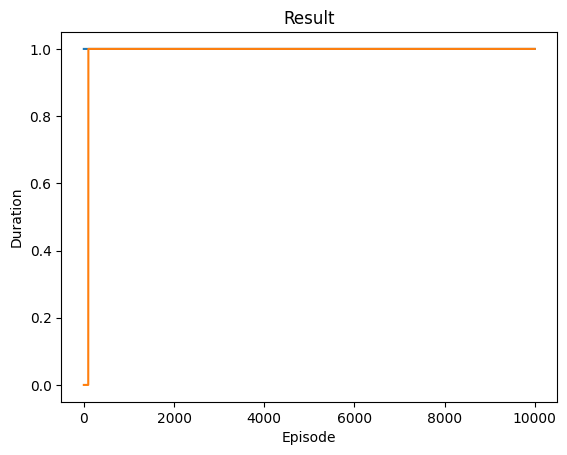

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 10_000
else:
    num_episodes = 1000

# 1) Reset env and get a sample obs
obs, _ = env.reset()

# 2) Preprocess it
processed = preprocessor(obs)   # should be a tensor of shape [1, D]

# 3) Extract D
state_dim = processed.shape[-1]
print(f"State dimension: {state_dim}")
agent1 = DQNAgent(n_observations, n_actions, device, state_dim)
agent2 = DQNAgent(n_observations, n_actions, device, state_dim)
# Usage example:
# agent = DQNAgent(n_observations, n_actions, device)
# state, _ = env.reset()
# state = preprocessor(state)
# action = agent.select_action(state)
# next_state, reward, done, _, _ = env.step(action.item())
# ... memory.push(state, action, reward, next_state) ...
# loss = agent.optimize_model()
# agent.update_target_network()


for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = preprocessor(state)
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for t in count():
        action1 = agent1.select_action(state)
        action2 = agent2.select_action(state)

        # Take a step in the environment
        observation, reward, terminated, truncated, _ = env.step((action1.item(), action2.item()))
        observation = preprocessor(observation)
        reward_agent1 = reward[0]
        reward_agent2 = reward[1]
        reward_agent1 = torch.tensor([reward_agent1], device=device)
        reward_agent2 = torch.tensor([reward_agent2], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        agent1.memory.push(state, action1, next_state, reward_agent1)
        agent2.memory.push(state, action2, next_state, reward_agent2)
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent1.optimize_model()
        agent2.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        agent1.update_target_network(tau=TAU)
        agent2.update_target_network(tau=TAU)
        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

<ipython-input-13-bf006f3f7417>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(processed_obs, dtype=torch.float32, device=device)


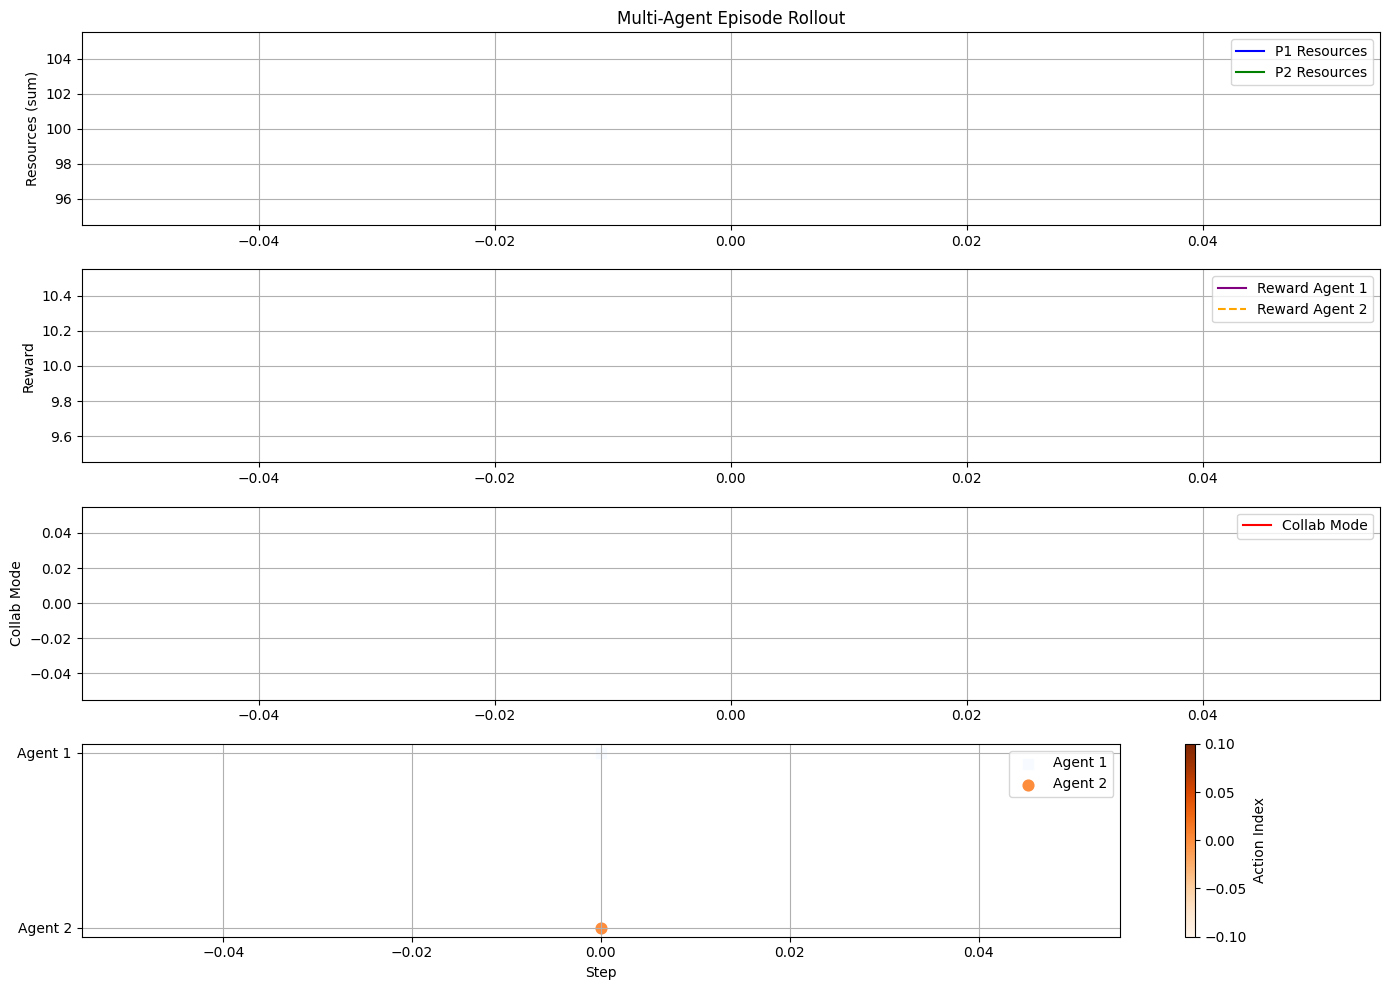

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def run_and_plot_episode_multiagent(agent1, agent2, env, preprocessor, device):
    obs, _ = env.reset()
    done = False
    steps = 0

    collab_trace = []
    p1_status_trace = []
    p2_status_trace = []
    p1_res_trace = []
    p2_res_trace = []
    action1_trace = []
    action2_trace = []
    reward1_trace = []
    reward2_trace = []

    while not done:
        # Preprocess observation
        processed_obs = preprocessor(obs)
        state = torch.tensor(processed_obs, dtype=torch.float32, device=device)
        if state.dim() == 1:
            state = state.unsqueeze(0)

        # Get actions from both agents
        action1 = agent1.policy_net(state).argmax(dim=1).item()
        action2 = agent2.policy_net(state).argmax(dim=1).item()

        # Record observation values
        collab_mode = obs["collab_mode"]
        p1_status = obs["party_1_status"]
        p2_status = obs["party_2_status"]
        p1_res = np.array(obs["party_1_resources"])
        p2_res = np.array(obs["party_2_resources"])

        collab_trace.append(collab_mode)
        p1_status_trace.append(p1_status)
        p2_status_trace.append(p2_status)
        p1_res_trace.append(np.sum(p1_res))  # e.g., sum of resource vector
        p2_res_trace.append(np.sum(p2_res))
        action1_trace.append(action1)
        action2_trace.append(action2)

        # Step environment
        obs, reward, done, _, _ = env.step((action1, action2))
        reward1_trace.append(reward[0])
        reward2_trace.append(reward[1])
        steps += 1

        if steps > 500:
            print("Episode cut off at 500 steps")
            break

    x = np.arange(len(action1_trace))

    plt.figure(figsize=(14, 10))

    plt.subplot(4, 1, 1)
    plt.plot(x, p1_res_trace, label="P1 Resources", color="blue")
    plt.plot(x, p2_res_trace, label="P2 Resources", color="green")
    plt.ylabel("Resources (sum)")
    plt.title("Multi-Agent Episode Rollout")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(x, reward1_trace, label="Reward Agent 1", linestyle='-', color='purple')
    plt.plot(x, reward2_trace, label="Reward Agent 2", linestyle='--', color='orange')
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(x, collab_trace, label="Collab Mode", color='red')
    plt.ylabel("Collab Mode")
    plt.grid(True)
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.scatter(x, [1]*len(x), c=action1_trace, cmap="Blues", label="Agent 1", marker='s', s=60)
    plt.scatter(x, [0]*len(x), c=action2_trace, cmap="Oranges", label="Agent 2", marker='o', s=60)
    plt.xlabel("Step")
    plt.yticks([0, 1], ["Agent 2", "Agent 1"])
    plt.grid(True)
    plt.colorbar(label="Action Index")
    plt.legend()

    plt.tight_layout()
    plt.show()

run_and_plot_episode_multiagent(agent1, agent2, env, preprocessor, device)